In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zeus21
from classy import Class
from scipy.special import spherical_jn

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [5]:
ClassCosmo = Class()
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 10}
ClassCosmo.set(params)
ClassCosmo.compute()

In [6]:
UserParams = zeus21.User_Parameters(precisionboost=1.2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

In [7]:
z = 0
k = np.linspace(0.001, 10, 50000)
pk = [ClassCosmo.pk(ki, z) for ki in k]
a = np.linspace(0.01, 1., 1000)
Omega_m0 = 0.31
Omega_L0 = 1. - Omega_m0

def integrand_v(r):
    return pk * spherical_jn(0, k*r)

def H(a):
    return np.sqrt(Omega_m0 * a**-3 + Omega_L0)

def D(a):
    integral = np.trapezoid(1 / (a**3 * (H(a))**3), a)
    D = 5 / 2 * Omega_m0 * H(a) * integral
    D_normalized = D / D[-1]
    return D_normalized

def dD_dtau(D, a):
    dD_da = np.gradient(D, a)
    return dD_da * a**2 * H(a)

dD_dtau_vals = dD_dtau(D(a), a)
D_dot = dD_dtau_vals[-1] # Linear perturbation growth factor
r_array = np.linspace(0.1, 1000, 10000)

def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
xi_v = [xi_v(r) for r in r_array]

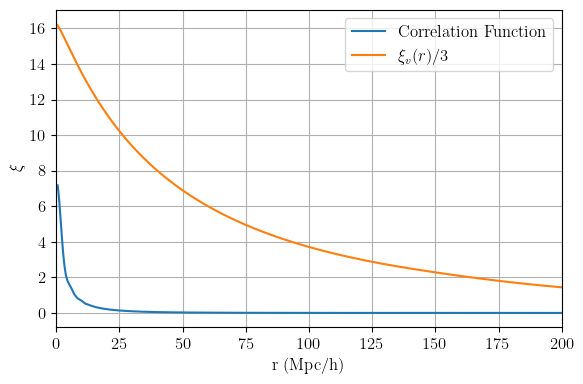

In [8]:
CF = CorrFClass.xi_RR_CF
r_list = CorrFClass.rlist_CF
plt.figure(figsize=(6, 4))
plt.plot(r_list, CF[0, 0, :], label='Correlation Function')
plt.plot(r_array, np.asarray(xi_v)/3, label=r'$\xi_v(r)/3$')
plt.xlim(0, 200)
plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi$')
plt.legend()
plt.grid()
plt.tight_layout()